In [2]:
from datascience import *
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [3]:
# data 불러오기
tb_data = Table.read_table('20141078_data.csv')

# target data인 6월 30일 데이터를 제외함
data    = pd.read_csv('20141078_data.csv').iloc[0:2880, :]

In [4]:
# 예측하고자 하는 데이터 분리
target_row     = np.array(list(range(24, 0, -1))) * (-1)

# 예측 대상의 값을 구함
target         = pd.read_csv('20141078_data.csv').iloc[target_row, :]
target         = target.transpose()
target.columns = list(target.iloc[0,:])
target         = target.drop('Time', axis = 0)
target_mean    = target.mean()

[0.771] [0.2309]


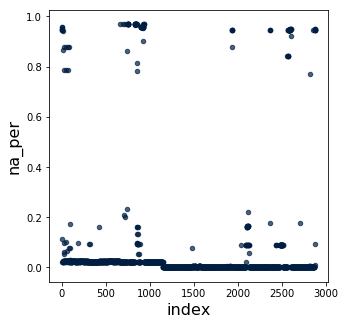

In [6]:
# na 비율을 구한다
na_per = []
for i in range(0, len(data)):
    na     = round(data.iloc[i,:].isnull().sum() / len(data.columns),4)
    na_per = np.append(na_per , na)


tb_na    = Table().with_columns('index', range(0,len(data)),
                                'Time', data['Time'],
                                'na_per', na_per)

tb_na.scatter('index', 'na_per')

# 2880개중 148개만이 na비율이 높음
a = tb_na.sort('na_per', descending = True).take(148)['na_per']
b = tb_na.sort('na_per', descending = True).take(149)['na_per']

# 148개가 77%넘는 비율로 결측치를 가지고 있다. 149번째 부터는 23% 미만의 결측치
print(a, b)

# Step1 .
### 각 column들의 평균과 분산을 통해 주택 데이터만 분리

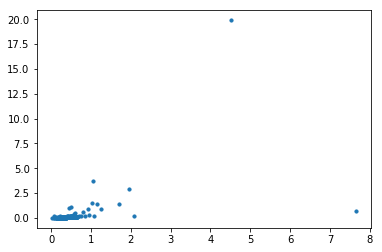

In [7]:
col_mean = []
col_var  = []

for i in range(1,len(tb_data.columns)):
    # 가구별 전력 사용량의 평균
    col_mean = col_mean + [np.nanmean(tb_data[i])]
    
    # 가구별 전력 사용량의 분산
    col_var  = col_var + [np.nanvar(tb_data[i])]


    
# 전력 사용량을 볼 수 있도록 table 생성
table = Table().with_columns('col_name', list(tb_data)[1:],
                             'col_mean', col_mean,
                             'col_var', col_var)

# 평균과 분산의 분포 확인
plt.scatter(table.column('col_mean'), table.column('col_var'), s = 10)

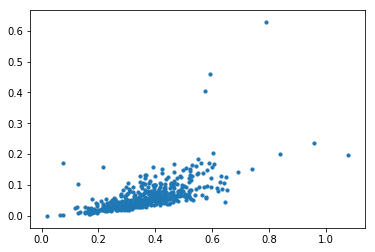

In [13]:
# 우리나라 주택 평균 사용량을 넘지 않는 건물 선정
table = table.sort('col_mean', descending = True)
table = table.where('col_mean', are.below(1.2))

# 우리나라 주택 평균 사용량의 분산이 넘지 않는 건물 선정
table = table.sort('col_var', descending = True)
table = table.where('col_var', are.below(0.8))

# 확인
plt.scatter(table.column('col_mean'), table.column('col_var'), s = 10)

# Step2 .
### 필요한 데이터 전치 후 저장

In [14]:
# 목표 col_name만 있는 데이터를 전치
data = data[list(table['col_name'])]

# data 변환
data            = data.transpose()

# data column 지정
data.columns    = list(tb_data['Time'][0:2880])

data
# 0행의 Time을 제거하고 transpose_data로 저장
data.to_csv('20141078_data2.csv')

# Step3 .
### 가정(주택의 동일한 시간대의 전력 사용량은 정규분포를 따를 것이다.)
#####  (동작하는데 오래걸려 데이터를 저장함)

In [15]:
# data 불러오기
data      = Table.read_table('20141078_data2.csv')
data_na   = data

In [16]:
data_mean = []
data_std  = []
data_time = []


total = tqdm_notebook(range(1, len(data)))

for i in total:
    # nan제외한 특정 시간대의 전력사용량 평균
    data_mean = data_mean + [np.nanmean(data.column(i))]
    
    # nan제외한 특정 시간대의 전력사용량 표준편차
    data_std  = data_std + [np.nanstd(data.column(i))]
    
    # 특정 시간
    data_time = np.array(list(data)[1:])
    
# array로 이용하기 위해 변환
data_mean = np.array(data_mean)

In [17]:
# 이때 bootsraping 사용하여 평균을 검증한다.
def bootstrap_mean(original_sample, label, replications):
    just_one_column = original_sample.select(label)
    means           = make_array()
    
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_mean   = np.nanmean(bootstrap_sample.column(0))
        means            = np.append(means, resampled_mean)
        
    return means

In [18]:
total    = tqdm_notebook(range(1, len(data)))
temp     = []


for i in total:
    # bootstrap을 이용하여 평균을 확인
    bstrap_medians = bootstrap_mean(data, tb_data['Time'][i - 1], 1000)
    
    # 95% 신뢰구간 생성
    left           = percentile(2.5, bstrap_medians)
    right          = percentile(97.5, bstrap_medians)
    
    # 95% 신뢰구간에 들어가지 않는 column의 번호를 저장
    if data_mean[i-1] < left or data_mean[i-1] > right :
        temp = np.append(temp, i)
        
# 95% 신뢰구간에 들어가지 않는 column들의 평균을 bootstrap을 통해 찾은 median으로 대체
for i in temp:
    bstrap_medians    = bootstrap_mean(data, tb_data['Time'][int(i)], 1000)
    data_mean[int(i)] = percentile(50, bstrap_medians)

C:\Users\ybahn\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [19]:
total = tqdm_notebook(range(1, len(data)))


# 각 column들에 대해
for i in total:
    k     = 0
    # num에 해당 column의 결측치의 수를 합산
    num     = pd.isnull(data.column(i)).sum()
    
    # 결측치의 수만큼 정규분포를 만듬
    na_list = np.round(np.random.normal(data_mean[i - 1], data_std[i - 1], num), 2) 
    
    # 행을 한줄씩 확인
    for j in range(0, len(data.column(1))) :
        # 만약 j행이 결측치라면 
        if pd.isnull(data.column(i)[j]) == True :
            # 해당 위치에 정규분포의 값 하나를 넣음
            data.column(i)[j] = na_list[k]
            k = k + 1

# 데이터를 저장
data.to_csv('20141078_data3.csv')

# Step4 .
### 평균을 그려보며 데이터의 형태를 확인

In [20]:
data  = Table.read_table('20141078_data3.csv')

In [21]:
time_mean  = Table().with_columns('index', range(0,len(data_mean)),
                                  'Time', list(data)[1:],
                                  'Mean', data_mean)

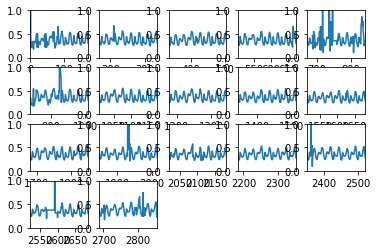

In [22]:
# 그래프를 그려서 데이터의 형태를 확인
x = time_mean['index']
y = time_mean['Mean']


len_list = []
for i in range(0,19,1):
    len_list = np.append(len_list, 168*i)


j = 1
for i in len_list:
    plt.subplot(4, 5, j)
    plt.plot(x,y)
    plt.ylim(0,1)
    plt.xlim(len_list[j-1], len_list[j])
    j = j + 1
    if j == 18 :
        break
plt.show()

# Step5 .
### 가설(6.30일 전력 사용량 또한 비슷한 패턴을 나타낼 것이다.)

In [23]:
# 정규분포를 이용한 결측치 보완 데이터의 패턴을 구함
future = []
past   = []
value  = []


# 특정 일을 비교
for i in range(0, 120):
    # 비교할 패턴
    check_val = time_mean['Mean'][(24*i) : (24*i) + 24]
    # 24시간 주기
    for j in range(1,120):
        # 열이 2880을 넘지 않도록 제한
        if (24*i + 24*(j+1)) > 2904:
            break
        else:
            future_val = time_mean['Mean'][(24*i + 24*j): (24*i + 24*(j+1))]
            # 열이 마지막 일인 경우 제한
            if len(future_val) == 0:
                break
            future_val = sum(abs(check_val - future_val))
            future     = np.append(future, future_val)
        
    # 24시간 주기
    for k in range(0,121):
        # 열이 0 미만으로 가지 않도록 제한
        if (24*i - 24*(k+1)) < 0 :
            break
        else:
            past_val   = time_mean['Mean'][24*i - 24*(k+1) : 24*i + 24*(-k)]
            # 열이 첫번째 일경우 제한
            if len(past_val) == 0:
                break
            past_val   = sum(abs(check_val - past_val))
            past       = np.append(past, past_val)
    
    # 길이가 0이면 mean함수가 작동하지 않으므로 조건을 수정
    if len(future) == 0 :
        mean = np.mean(past)
        
    elif len(past) == 0:
        mean = np.mean(future)
    
    # 평균을 구함
    else :
        mean = (np.mean(future)+ np.mean(past))/2
    
    
    
    value = np.append(value, mean)
    
# 구한 평균들 중 가장 작은 값을 찾고 해당 값을 반환하여 언제의 날짜가 가장 적합한 패턴인지 찾음    
for i in range(0,len(value)):
    if np.nanmin(value) == value[i]:
        pattern = time_mean['Mean'][(24*i) : (24*i) + 24]
        print(i, 'is best pattern')    
pattern

26 is best pattern


array([0.36250797, 0.30383865, 0.2787251 , 0.26772908, 0.26530677,
       0.27740239, 0.34528884, 0.43685857, 0.38950398, 0.34417131,
       0.31653785, 0.29358964, 0.29667396, 0.28503579, 0.29278131,
       0.28654672, 0.30830478, 0.36243227, 0.42623506, 0.49971315,
       0.50835458, 0.50324502, 0.47785458, 0.42949402])

# Step6 .
### 평균을 이용한 결측치 대체 data에도 같은 작업을 반복
#### (오래걸려 데이터를 저장)

In [24]:
data_na_mean = []
data_na_std  = []
data_na_time = []


total = tqdm_notebook(range(1, len(data)))

for i in total:
    # nan제외한 특정 시간대의 전력사용량 평균
    data_na_mean = data_na_mean + [np.nanmean(data_na.column(i))]
    
    # nan제외한 특정 시간대의 전력사용량 표준편차
    data_na_std  = data_na_std + [np.nanstd(data_na.column(i))]
    
    # 특정 시간
    data_na_time = np.array(list(data_na)[1:])
    
# array로 이용하기 위해 변환
data_na_mean = np.array(data_na_mean)

In [26]:
# 정규분포와 비교하기 위해 우리나라 가구 전력 사용 평균인 1을 24시간으로 나눈 값을 대체한 data를 만든다.
total = tqdm_notebook(range(1, len(data)))

for i in total:
    for j in range(0,len(data.column(1))) :
        if pd.isnull(data.column(i)[j]) == True :
            data_na.column(i)[j] = round(1/24,3)
            
data_na.to_csv('20141078_data4.csv')

In [30]:
data_na     = table.read_table('20141078_data4.csv')

time_mean2  = Table().with_columns('index', range(0,len(data_na_mean)),
                                   'Time', list(data_na)[1:],
                                   'Mean', data_na_mean)

In [31]:
# 평균을 이용한 결측치 보완 데이터의 패턴을 구함
future = []
past   = []
value  = []


# 특정 일을 비교
for i in range(0, 120):
    # 비교할 패턴
    check_val = time_mean2['Mean'][(24*i) : (24*i) + 24]
    # 24시간의 주기
    for j in range(1,120):
        if (24*i + 24*(j+1)) > 2904:
            break
        else:
            future_val = time_mean2['Mean'][(24*i + 24*j): (24*i + 24*(j+1))]
            if len(future_val) == 0:
                break
            future_val = sum(abs(check_val - future_val))
            future     = np.append(future, future_val)
        
    
    for k in range(0,121):
        if (24*i - 24*(k+1)) < 0 :
            break
        else:
            past_val   = time_mean2['Mean'][24*i - 24*(k+1) : 24*i + 24*(-k)]
            if len(past_val) == 0 :
                break
            past_val   = sum(abs(check_val - past_val))
            past       = np.append(past, past_val)
    
    if len(future) == 0 :
        mean = np.mean(past)
        
    elif len(past) == 0:
        mean = np.mean(future)
    
    else :
        mean = (np.mean(future)+ np.mean(past))/2
    
    
    
    value = np.append(value, mean)
    
    
for i in range(0,len(value)):
    if np.nanmin(value) == value[i]:
        pattern2 = time_mean2['Mean'][(24*i) : (24*i) + 24]
        print(i, 'is best pattern')    
pattern2

26 is best pattern


array([0.36105479, 0.30249902, 0.27845401, 0.26594912, 0.26687671,
       0.27801566, 0.34548924, 0.43305871, 0.38968885, 0.34609393,
       0.31585519, 0.29389824, 0.29500391, 0.28667906, 0.2936771 ,
       0.28620939, 0.30858904, 0.36328963, 0.42741683, 0.49764384,
       0.50992955, 0.50305088, 0.47934051, 0.43083366])

# Step7 .
### 구한 pattern들을 비교

In [32]:
# 새로 구한 pattern과 target이 담긴 table 생성
tb_pattern = Table().with_columns('Time', list(target),
                                  'pattern', pattern,
                                  'pattern2', pattern2,
                                  'target', target_mean)


# 예측을 하지 않고 단순 비교한 mse
mse_pattern  = np.mean((tb_pattern['target'] - tb_pattern['pattern']) ** 2)
mse_pattern2 = np.mean((tb_pattern['target'] - tb_pattern['pattern2']) **2)

mse_pattern, mse_pattern2

(0.04303871991532551, 0.043080063606335255)

In [33]:
# mse를 구하는 함수 생성
def pattern_predict_mse(a,b):
    x      = tb_pattern['pattern']
    y      = tb_pattern['target']
    fitted = a*x + b
    return np.mean((y - fitted) ** 2)

def pattern2_predict_mse(a,b):
    x      = tb_pattern['pattern2']
    y      = tb_pattern['target']
    fitted = a*x + b
    return np.mean((y - fitted) ** 2)

In [34]:
# 선형관계가 있다고 보여지기 때문에 1차 선형관계에서의 mse 최소값을 갖게하는 a와 b값을 찾음
minimize(pattern_predict_mse)

pattern_predict_mse(0.66878571, 0.21471079)

0.02636897347708611

In [35]:
# 평균을 이용한 data 결측치 보완의 mse 최소값을 찾음
minimize(pattern2_predict_mse)

pattern2_predict_mse(0.64899877, 0.25146606)

0.025297327167619083

In [38]:
# 만든 모든 값들을 볼 수 있는 table 생성
tb_predict = Table().with_columns('Time', list(target),
                                  'target', tb_pattern['target'],
                                  'predict', (0.64689266 * tb_pattern['pattern'] + 0.25211165),
                                  'predict2', 0.648999877 * tb_pattern['pattern2'] + 0.25146606)

tb_predict.show(5)

Time,target,predict,predict2
2018-06-30 0:00,0.916615,0.486615,0.485791
2018-06-30 1:00,0.902769,0.448663,0.447788
2018-06-30 2:00,0.177464,0.432417,0.432183
2018-06-30 3:00,0.289377,0.425304,0.424067
2018-06-30 4:00,0.283916,0.423737,0.424669


In [39]:
# 실제 데이터와 예측한 값들의 하루 사용량을 확인한다.
sum(tb_predict['target']) , sum(tb_predict['predict']), sum(tb_predict['predict2'])


# 실제 데이터와 예측한 값들의 하루사용량 차이를 계산한다.
difference = sum(tb_predict['target']) - (sum(tb_predict['predict']), sum(tb_predict['predict2']))


# 둘중 어느 값의 차이가 더 큰지 확인한다.
difference[0] > difference[1]

True